In [71]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output
import shutil

from utils import patient, dataset_INCan

In [100]:
def registrater_affine(fixed:sitk.Image, moving:sitk.Image, show=False):
    """registration of two sitk images using affine transformation

    Args:
        fixed (sitk.Image): fixed image. In CEDM SET, it is the image with contrast enhancement
        moving (sitk.Image): moving image, in CEDM is the image before contrast injection

    Returns:
        sitk.ParameterMap: transform parameters
    """
    # register
    parameterMap = sitk.GetDefaultParameterMap('affine')
    parameterMap['NumberOfSpatialSamples'] = ['5000']
    #run registration
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed)
    elastixImageFilter.SetMovingImage(moving)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    #save transform parameters
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()

    
    clear_output(wait=show)

    return transformParameterMap

def transformation(im: sitk.Image, parameterMap_path:str, format='np', show=False):
    """apply transformation to an image

    Args:
        im (sitk.Image): image to be transformed
        parameterMap (sitk.ParameterMap): transformation settings
        format (str, optional): output format. Defaults to 'np'.

    Returns:
        np.array or sitk.Image: transformed image
    """
    transformixImageFilter = sitk.TransformixImageFilter()
    parameterMap = sitk.ReadParameterFile(str(parameterMap_path))
    transformixImageFilter.SetTransformParameterMap(parameterMap)
    transformixImageFilter.SetMovingImage(im)
    transformixImageFilter.Execute()
    im_result = transformixImageFilter.GetResultImage()
    clear_output(wait=show)
    if format=='sitk':
        return im_result
    elif format=='np':
        im_array = sitk.GetArrayFromImage(im_result)
        im_array = im_array.astype(np.uint16)
        return im_array
    else:
        raise ValueError('format must be "sitk" or "np"')

In [101]:
pat_num = '2'
pat = patient(pat_num=pat_num)
#define fixed and moving
fixedImage = pat.get_im(sequence='CMC', format = 'sitk')
movingImage = pat.get_im(sequence='SMC', format='sitk')

parameterMap = registrater_affine(fixedImage, movingImage, show=False)
# move created files radiomics/TransformParameters.0.txt to data
shutil.move('TransformParameters.0.txt', repo_path / f'data/registration/transform_{pat_num}.txt')

im_transformed = transformation(movingImage, repo_path / f'data/registration/transform_{pat_num}.txt', format='sitk')

Min and max of fixed: 11919, 14659
Min and max of moving: 11341, 14659
Min and max of substraction: -14629, 254


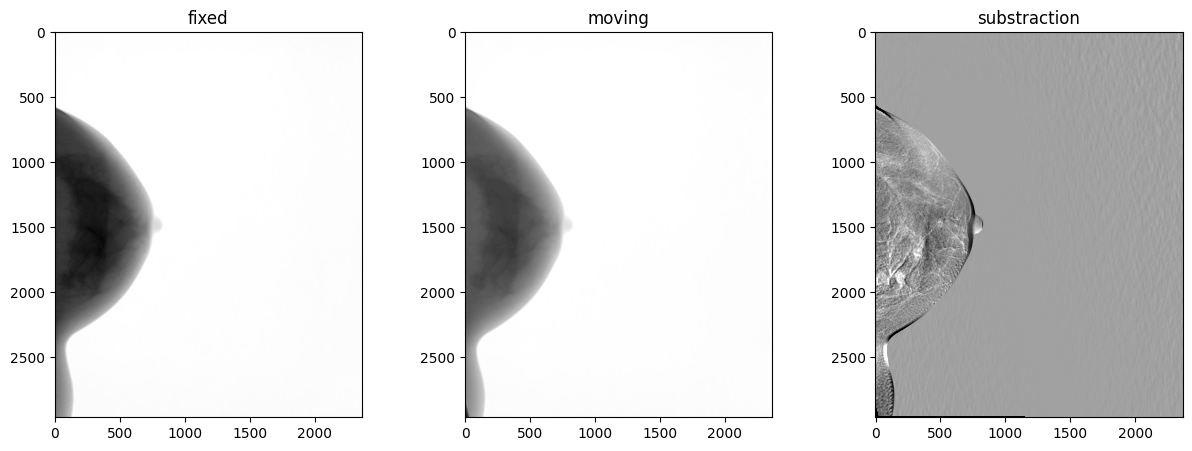

In [103]:
fixed_array = sitk.GetArrayFromImage(fixedImage)
im_transformed_array = sitk.GetArrayFromImage(im_transformed)

im_substraction = -(fixed_array.astype(np.int32) - im_transformed_array.astype(np.int32)).astype(np.int16)


# show orignal images and registration
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(sitk.GetArrayFromImage(fixedImage), cmap='gray')
ax[0].set_title('fixed')
ax[1].imshow(sitk.GetArrayFromImage(movingImage), cmap='gray')
ax[1].set_title('moving')
ax[2].imshow(im_substraction, cmap='gray', vmin=-112, vmax=65)
ax[2].set_title('substraction')


print(f'Min and max of fixed: {sitk.GetArrayFromImage(fixedImage).min()}, {sitk.GetArrayFromImage(fixedImage).max()}')
print(f'Min and max of moving: {sitk.GetArrayFromImage(movingImage).min()}, {sitk.GetArrayFromImage(movingImage).max()}')
print(f'Min and max of substraction: {im_substraction.min()}, {im_substraction.max()}')

In [ ]:
def registration_computing(info):
    """returns a list of parameter maps for each patient in info

    Args:
        info (obj): object with metadata of patients

    Returns:
        list: list with parameter maps
    """
    
    
        

In [2]:
def substract(im_base, im_restant, x_trans, y_trans, pat_num, sitk_im=False, reference_path=None, save=False):
    """given base and restant images, substract restant from base and return the result
    Minimum value of substraction is shifted to 0 to become uint16 image

    Args:
        im_base (array): base image
        im_restant (array): restant image
        sitk_im (bool, optional): if True, the image is a sitk obj using SET as reference image. Defaults to False.
        reference_path (str, optional): path to SET reference image. Defaults to None.

    Returns:
        array or sitk image: uint16 image with the substraction
    """
    #Subsract using im_base as reference and transform to int32 for negative values
    im_substraction = (im_base.astype(np.int32) - im_restant.astype(np.int32))
    #shift intensities to be uint16
    im_substraction = (im_substraction + 33152).astype(np.uint16) #save with original dtype
    utils.min_max(im_substraction, show=True)

    if save:
        utils.save_as_nifti(im_substraction,
                            filename=str(repo_path / f'data/substracted_images/Pat_{pat_num}_CMC-SMC_x{x_trans}_y{y_trans}.tif'),
                            reference_path=str(reference_path))
    if sitk_im: #in case of sitk image
        reference_image = sitk.ReadImage(reference_path)
        im_substraction = sitk.GetImageFromArray(im_substraction)
        im_substraction.SetOrigin(reference_image.GetOrigin())
        im_substraction.SetSpacing(reference_image.GetSpacing())
        im_substraction.SetDirection(reference_image.GetDirection())
        return im_substraction
    #else return array
    return im_substraction

def extractor_settings(param_path, show=False):
    """set extraction settings for pyradiomics

    Args:
        param_path (str): relative path of parameter file
        show (bool, optional): if printing setting or not. Defaults to False.

    Returns:
        obj: extractor of pyradiomics
    """
    extractor = featureextractor.RadiomicsFeatureExtractor(str(repo_path /param_path))
    if show:
        print('Extraction parameters:\n\t', extractor.settings)
        print('Enabled filters:\n\t', extractor.enabledImagetypes)
        print('Enabled features:\n\t', extractor.enabledFeatures)
    return extractor